In [1]:
from ROOT import TMVA, TFile, TTree, TCut, TString
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Concatenate, Dense, LSTM, Input, concatenate, SimpleRNN, GRU, Masking, Lambda, Reshape, Dropout, RNN
from tensorflow.keras.optimizers import Adagrad, SGD, RMSprop, Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
from IPython.display import display
import graphviz
from numba import cuda
from array import array
import pickle
import scikitplot as skplt
import seaborn as sns
from tensorflow.keras.utils import plot_model
import pydot

Welcome to JupyROOT 6.19/01


Load signal and background trees

In [2]:
def min_max_renormal(numpy_array):
    mydf=pd.DataFrame(data=numpy_array)
    normalize_df=(mydf-mydf.min())/(mydf.max()-mydf.min())
    normalize_np=normalize_df.values
    print(normalize_np)
    return(normalize_np)

In [3]:
signalFile=TFile.Open("4l-TMVA/tree_ewk_mytrain.root")
backgroundFile=TFile.Open("4l-TMVA/tree_QCD_mytrain.root")

In [4]:
signalTree=signalFile.Get("tree_NOMINAL")
backgroundTree=backgroundFile.Get("tree_NOMINAL")

In [5]:
signalNum=signalTree.GetEntries()
backgroundNum=backgroundTree.GetEntries()
print("signal events number before cut is: ",signalNum)
print("background events number before cut is: ",backgroundNum)

signal events number before cut is:  223401
background events number before cut is:  279340


Convert minitree into numpy

In [6]:
signalArray=signalTree.AsMatrix(["weightr","MJJ","MZZ","dYJJ","PtZZ","PtZ1","PtJ1","PtJ2","YJ1xJ2","PtL3","YZ1Star",
                                "YZ2Star","PtZZJJOHtZZJJ"])
backgroundArray=backgroundTree.AsMatrix(["weightr","MJJ","MZZ","dYJJ","PtZZ","PtZ1","PtJ1","PtJ2","YJ1xJ2","PtL3","YZ1Star",
                                "YZ2Star","PtZZJJOHtZZJJ"])

In [7]:
dataSignal=pd.DataFrame(data=signalArray[:,1:],columns=["MJJ","MZZ","dYJJ","PtZZ","PtZ1","PtJ1","PtJ2","YJ1xJ2","PtL3","YZ1Star",
                                "YZ2Star","PtZZJJOHtZZJJ"])

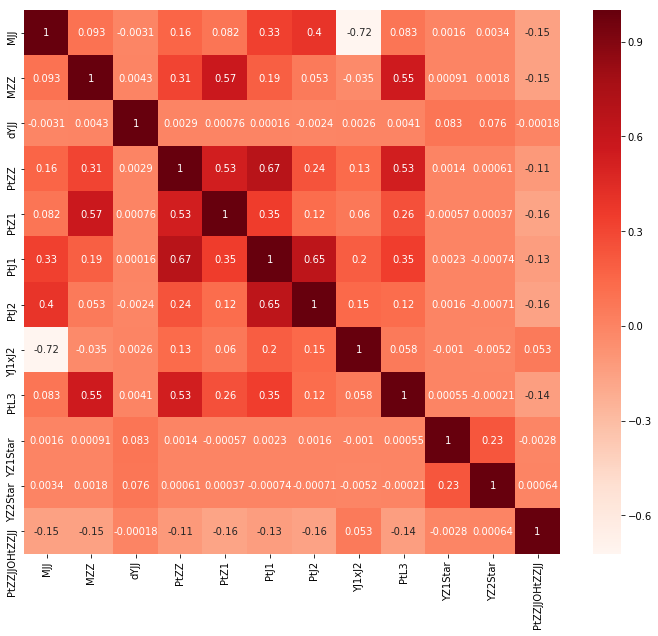

In [8]:
plt.figure(figsize=(12,10))
cor = dataSignal.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

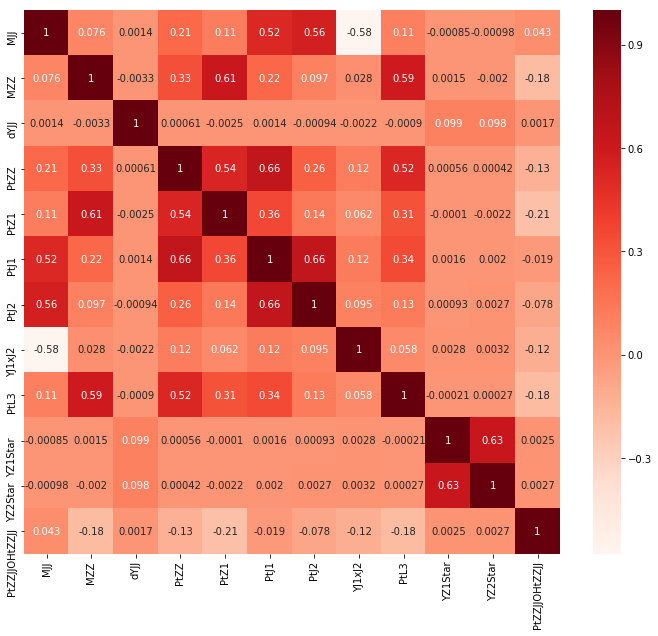

In [9]:
dataBackground=pd.DataFrame(data=backgroundArray[:,1:],columns=["MJJ","MZZ","dYJJ","PtZZ","PtZ1","PtJ1","PtJ2","YJ1xJ2","PtL3","YZ1Star",
                                "YZ2Star","PtZZJJOHtZZJJ"])
plt.figure(figsize=(12,10))
cor = dataBackground.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()


In [10]:
print(signalArray)

[[ 7.93955566e-05  1.10154873e+03  2.21385879e+02 ... -2.03438704e-01
  -7.17892966e-01  2.47319219e-01]
 [ 6.81283983e-05  8.88801935e+02  4.55076482e+02 ...  2.26838329e-01
  -6.34519528e-01  8.35550913e-02]
 [ 7.11882814e-05  1.39131227e+03  4.18144039e+02 ...  1.32187581e+00
  -1.33197312e+00  7.07480238e-02]
 ...
 [ 1.53771444e-04  8.24401842e+02  2.79273295e+02 ...  1.37421096e+00
   3.21475295e-01  2.03029652e-01]
 [ 1.43034199e-04  8.57515774e+02  1.86559830e+02 ... -4.43191963e-01
  -8.43641431e-01  1.82698382e-01]
 [ 2.06428744e-04  2.63357400e+03  3.88897812e+02 ...  9.54711913e-01
   1.37531098e+00  4.99991020e-02]]


In [11]:
print(signalArray[:,1])

[1101.54872881  888.80193472 1391.31226846 ...  824.4018424   857.51577443
 2633.5740049 ]


Add signal Region cuts $m_{jj}>300$ Gev and $|\Delta(y_{jj})|>2.0$.

In [12]:
signalSample=signalArray[(abs(signalArray[:,3])>2.0)&(signalArray[:,1]>300)]
backgroundSample=backgroundArray[(abs(backgroundArray[:,3])>2.0)&(backgroundArray[:,1]>300)]

In [13]:
print(len(signalSample))
print(len(backgroundSample))

184569
100683


In [14]:
signalNum=len(signalSample)
backgroundNum=len(backgroundSample)
print("signal event number after cut is: ",signalNum)
print("background event number after cut is:",backgroundNum)

signal event number after cut is:  184569
background event number after cut is: 100683


Split datasets into training and testing subsets

In [15]:
trainingRatio=0.8
sigTrainNum=int(signalNum*0.8)
backgroundTrainNum=int(backgroundNum*0.8)
sigTestNum=signalNum-sigTrainNum
backgroundTestNum=backgroundNum-backgroundTrainNum
print("training signal events number is: ",sigTrainNum)
print("testing signal events number is: ",sigTestNum)
print("training background events number is: ",backgroundTrainNum)
print("testing background events number is: ",backgroundTestNum)


training signal events number is:  147655
testing signal events number is:  36914
training background events number is:  80546
testing background events number is:  20137


In [16]:
signal_row=np.arange(0,signalNum-1,1)
background_row=np.arange(0,backgroundNum-1,1)
signal_train_row=np.random.choice(signal_row,size=sigTrainNum,replace=False)
background_train_row=np.random.choice(background_row,size=backgroundTrainNum,replace=False)
label_signal_train=np.ones((sigTrainNum,1))
label_background_train=np.zeros((backgroundTrainNum,1))
label_signal_test=np.ones((sigTestNum,1))
label_background_test=np.zeros((backgroundTestNum,1))
signalTrain=signalSample[signal_train_row,:]
signalTest=np.delete(signalSample,signal_train_row,axis=0)
backgroundTrain=backgroundSample[background_train_row,:]
backgroundTest=np.delete(backgroundSample,background_train_row,axis=0)
signalTrain=np.concatenate((label_signal_train,signalTrain),axis=1)
backgroundTrain=np.concatenate((label_background_train,backgroundTrain),axis=1)
signalTest=np.concatenate((label_signal_test,signalTest),axis=1)
backgroundTest=np.concatenate((label_background_test,backgroundTest),axis=1)
ratio=sum(signalTrain[:,1])/sum(backgroundTrain[:,1])
signalTrain[:,1]=signalTrain[:,1]/ratio
print(backgroundTest)

[[ 0.00000000e+00  7.95021822e-04  7.83010817e+02 ... -3.96922332e-01
   4.76950877e-01  5.57478742e-02]
 [ 0.00000000e+00  1.05015350e-03  3.19712544e+02 ...  2.03881759e+00
   2.63145085e+00  5.32918716e-02]
 [ 0.00000000e+00 -4.16237187e-03  3.20863419e+02 ...  1.09982250e+00
   4.79696004e-01  3.49002896e-01]
 ...
 [ 0.00000000e+00  1.02402345e-03  4.79340214e+02 ...  5.12988428e-01
  -2.00449191e+00  1.48008102e-02]
 [ 0.00000000e+00  8.89092390e-04  1.26493593e+03 ... -8.72307436e-02
   1.41444303e+00  1.63736675e-01]
 [ 0.00000000e+00  3.61952304e-03  6.06729492e+02 ... -4.34869950e-01
  -3.75516061e-01  1.24633166e-02]]


In [17]:
dataTrain=np.vstack((signalTrain,backgroundTrain))
dataTest=np.vstack((signalTest,backgroundTest))
np.random.shuffle(dataTrain)
np.random.shuffle(dataTest)
dataTrainLabel=dataTrain[:,0]
dataTrainWeight=dataTrain[:,1]
dataTrainSample=dataTrain[:,2:]
dataTestLabel=dataTest[:,0]
dataTestWeight=dataTest[:,1]
dataTestSample=dataTest[:,2:]
tf.cast(dataTrainLabel,tf.float32)
tf.cast(dataTrainSample,tf.float32)

<tf.Tensor 'Cast_1:0' shape=(228201, 12) dtype=float32>

Signal and background training sets should have same yield in training

(array([61.78411162,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , 61.78411162]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

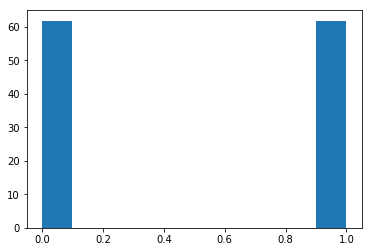

In [18]:
plt.hist(dataTrain[:,0],weights=dataTrain[:,1])

In [20]:
dataTrainSample1=min_max_renormal(dataTrainSample)

[[0.04672843 0.06080817 0.72164507 ... 0.4531626  0.4228205  0.12381645]
 [0.0925312  0.1379623  0.65928864 ... 0.42792828 0.3921066  0.18127127]
 [0.01862629 0.02048693 0.64435532 ... 0.47231342 0.47626925 0.05839411]
 ...
 [0.02293685 0.11256699 0.72257963 ... 0.62378798 0.42496739 0.03407949]
 [0.11218549 0.09912621 0.7627165  ... 0.59013372 0.26605341 0.07737289]
 [0.03203843 0.07427796 0.26421211 ... 0.5073375  0.31165445 0.05805586]]


Build model

In [21]:
model = Sequential()
model.add(Dense(300, kernel_initializer="random_normal", activation="relu",
    input_dim=12))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(1, kernel_initializer="random_uniform", activation="sigmoid"))

# Set loss, optimizer and evaluation metrics
model.compile(
     loss="binary_crossentropy",
     optimizer="adam",
     metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.


In [22]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='acc',
                              min_delta=0,
                              patience=4,
                              verbose=0, mode='auto')

In [23]:
model.save('model_4lNN.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               3900      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_4 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 301       
Total params: 365,401
Trainable params: 365,401
Non-trainable params: 0
_________________________________________________________________


2019-07-01 10:53:15.894619: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2019-07-01 10:53:15.898180: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3600000000 Hz
2019-07-01 10:53:15.898623: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x55951e3bc5e0 executing computations on platform Host. Devices:
2019-07-01 10:53:15.898638: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2019-07-01 10:53:15.966777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-07-01 10:53:15.967113: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x5595189c0bd0 executing computations on platform CUDA. Devices:
2019-07-01 10:53:15.967126: I t

In [24]:
history=model.fit(dataTrainSample1,dataTrainLabel,batch_size=100, epochs=30,
          sample_weight=dataTrainWeight,
          validation_split=0.2,
          callbacks=[early_stopping])

Train on 182560 samples, validate on 45641 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
182560/182560 [==============================] - 7s 40us/sample - loss: 0.4953 - acc: 0.7402 - val_loss: 0.4745 - val_acc: 0.7448
Epoch 2/30
182560/182560 [==============================] - 9s 51us/sample - loss: 0.4679 - acc: 0.7566 - val_loss: 0.4660 - val_acc: 0.7788
Epoch 3/30
182560/182560 [==============================] - 7s 39us/sample - loss: 0.4608 - acc: 0.7620 - val_loss: 0.4612 - val_acc: 0.7571
Epoch 4/30
182560/182560 [==============================] - 9s 51us/sample - loss: 0.4568 - acc: 0.7622 - val_loss: 0.4544 - val_acc: 0.7701
Epoch 5/30
182560/182560 [==============================] - 9s 52us/sample - loss: 0.4553 - acc: 0.7644 - val_loss: 0.4561 - val_acc: 0.7589
Epoch 6/30
182560/182560 [==============================] - 8s 45us/sample - loss: 0.4537 - acc: 0.7671 - val_loss: 0.4652 - val_acc: 0.7527
Epoch 7/30
182560/182560 [=============================

2019-07-01 10:53:17.529594: I tensorflow/stream_executor/dso_loader.cc:152] successfully opened CUDA library libcublas.so.10.0 locally


In [25]:
plot_model(model, to_file='model_4l.png')

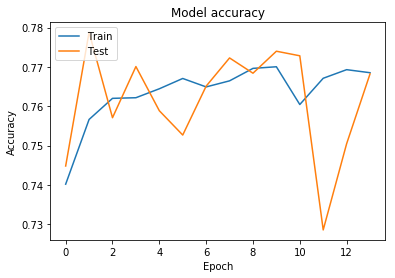

In [26]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [30]:
signalSample1=min_max_renormal(signalSample[:,1:])
backgroundSample1=min_max_renormal(backgroundSample[:,1:])

[[0.10806718 0.0221384  0.67581041 ... 0.50404466 0.41835862 0.24994773]
 [0.07938368 0.08695074 0.67827412 ... 0.55494359 0.42826787 0.08434809]
 [0.14713444 0.07670781 0.18427942 ... 0.68447931 0.34537285 0.07139748]
 ...
 [0.07070096 0.03819305 0.67877519 ... 0.69067021 0.54189151 0.20516175]
 [0.07516553 0.01247966 0.34838574 ... 0.47568343 0.40341294 0.18460261]
 [0.31462191 0.06859658 0.84317295 ... 0.64104624 0.6671439  0.050416  ]]
[[0.24056991 0.2782547  0.20873124 ... 0.56776604 0.29931715 0.23638323]
 [0.05400878 0.02471575 0.281767   ... 0.45249868 0.54884582 0.0567585 ]
 [0.01387425 0.02636357 0.67585237 ... 0.53860943 0.40094554 0.55899389]
 ...
 [0.03706912 0.02126497 0.70779724 ... 0.62629103 0.64399508 0.14916407]
 [0.01759261 0.03701945 0.30179983 ... 0.1849476  0.37799303 0.11765801]
 [0.03429722 0.01580314 0.69454218 ... 0.44835164 0.45501114 0.01243717]]


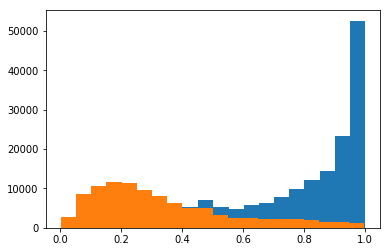

In [31]:
signalNN=model.predict(signalSample1)
backgroundNN=model.predict(backgroundSample1)
plt.hist(signalNN,bins=20)
plt.hist(backgroundNN,bins=20)
NNTrainScore=model.predict(dataTrainSample1)

In [32]:
backgroundNN=model.predict(backgroundSample1)
plt.hist(backgroundNN,bins=20)

(array([ 2664.,  8588., 10702., 11577., 11435.,  9696.,  8022.,  6272.,
         5070.,  5097.,  3375.,  2567.,  2557.,  2301.,  2234.,  2175.,
         2024.,  1597.,  1586.,  1144.]),
 array([0.00306213, 0.05278965, 0.10251717, 0.15224469, 0.20197222,
        0.25169975, 0.30142725, 0.35115477, 0.4008823 , 0.4506098 ,
        0.50033736, 0.55006486, 0.59979236, 0.6495199 , 0.6992474 ,
        0.7489749 , 0.7987025 , 0.84843   , 0.8981575 , 0.94788504,
        0.99761254], dtype=float32),
 <a list of 20 Patch objects>)

Save NN model to h5 file

In [35]:
model.save('model_4lNN.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               3900      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_4 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 301       
Total params: 365,401
Trainable params: 365,401
Non-trainable params: 0
_________________________________________________________________


In [33]:
signalNNScore=model.predict(signalSample1)
#backgroundNNScore=model.predict(backgroundArray[:,1:])
print(signalNNScore)

[[0.6355006 ]
 [0.8393171 ]
 [0.9713247 ]
 ...
 [0.5276623 ]
 [0.7175772 ]
 [0.99039245]]


In [34]:
plt.hist(signalNNScore,bins=20)

(array([  539.,  1625.,  2618.,  3822.,  4674.,  5192.,  5620.,  5359.,
         5387.,  7086.,  5387.,  4840.,  5865.,  6323.,  7789.,  9963.,
        12083., 14343., 23428., 52626.]),
 array([0.00548619, 0.05521168, 0.10493717, 0.15466267, 0.20438816,
        0.25411364, 0.30383915, 0.35356462, 0.40329012, 0.4530156 ,
        0.5027411 , 0.5524666 , 0.6021921 , 0.6519176 , 0.70164305,
        0.7513685 , 0.80109406, 0.8508195 , 0.900545  , 0.95027053,
        0.999996  ], dtype=float32),
 <a list of 20 Patch objects>)

In [36]:
def baseline_model():
    model = Sequential()
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu",
    input_dim=12))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(1, kernel_initializer="random_uniform", activation="sigmoid"))
    model.compile(
     loss="binary_crossentropy",
     optimizer="adam",
     metrics=["accuracy"])
    return model

    

In [37]:
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=30, batch_size=50, verbose=False)
estimator.fit(dataTrainSample1,dataTrainLabel,sample_weight=dataTrainWeight)
perm = PermutationImportance(estimator, random_state=1).fit(dataTrainSample1,dataTrainLabel)
eli5.show_weights(perm)

In [38]:
eli5.show_weights(perm,feature_names=["MJJ","MZZ","dYJJ","PtZZ","PtZ1","PtJ1","PtJ2","YJ1xJ2","PtL3","YZ1Star",
                                "YZ2Star","PtZZJJOHtZZJJ"])

In [39]:
cuda.select_device(0)
cuda.close()

In [51]:
varname=["MJJ","MZZ","dYJJ","PtZZ","PtZ1","PtJ1","PtJ2","YJ1xJ2","PtL3","YZ1Star",
                                "YZ2Star","PtZZJJOHtZZJJ"]
BDTtrain=xgb.DMatrix(dataTrainSample,label=dataTrainLabel,weight=dataTrainWeight,feature_names=varname)
BDTtest=xgb.DMatrix(dataTestSample,label=dataTestLabel,weight=dataTestWeight,feature_names=varname)
BDTSignal=xgb.DMatrix(signalArray[:,1:],feature_names=varname)
BDTBackground=xgb.DMatrix(backgroundArray[:,1:],feature_names=varname)
param = {'max_depth': 5, 'eta': 1.0, 'silent': 0, 'objective': 'binary:logistic'}
param['nthread'] = 16
param['eval_metric'] = 'auc'
param['tree_method'] = 'gpu_hist'
param['grow_policy'] = 'lossguide'
param['subsample']=0.9
evallist = [(BDTtest, 'eval'), (BDTtrain, 'train')]

/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndar

In [52]:
num_round = 1000
GBDT = xgb.train(param, BDTtrain, num_round, evallist)

[0]	eval-auc:0.793312	train-auc:0.796473
[1]	eval-auc:0.824212	train-auc:0.828784
[2]	eval-auc:0.840803	train-auc:0.844828
[3]	eval-auc:0.847249	train-auc:0.851817
[4]	eval-auc:0.851453	train-auc:0.855943
[5]	eval-auc:0.852541	train-auc:0.857913
[6]	eval-auc:0.854584	train-auc:0.860177
[7]	eval-auc:0.85593	train-auc:0.861807
[8]	eval-auc:0.856812	train-auc:0.862772
[9]	eval-auc:0.857454	train-auc:0.863585
[10]	eval-auc:0.857845	train-auc:0.864167
[11]	eval-auc:0.858636	train-auc:0.864997
[12]	eval-auc:0.859046	train-auc:0.865545
[13]	eval-auc:0.859388	train-auc:0.865986
[14]	eval-auc:0.859711	train-auc:0.866555
[15]	eval-auc:0.860183	train-auc:0.867147
[16]	eval-auc:0.860678	train-auc:0.867566
[17]	eval-auc:0.861216	train-auc:0.868252
[18]	eval-auc:0.861423	train-auc:0.868581
[19]	eval-auc:0.861475	train-auc:0.868933
[20]	eval-auc:0.8618	train-auc:0.86941
[21]	eval-auc:0.862098	train-auc:0.869867
[22]	eval-auc:0.862468	train-auc:0.870229
[23]	eval-auc:0.862604	train-auc:0.870433
[24]	e

[194]	eval-auc:0.867529	train-auc:0.886956
[195]	eval-auc:0.867608	train-auc:0.886997
[196]	eval-auc:0.867487	train-auc:0.887011
[197]	eval-auc:0.867478	train-auc:0.88706
[198]	eval-auc:0.867568	train-auc:0.887127
[199]	eval-auc:0.867589	train-auc:0.887204
[200]	eval-auc:0.867663	train-auc:0.887248
[201]	eval-auc:0.867572	train-auc:0.887313
[202]	eval-auc:0.867499	train-auc:0.887324
[203]	eval-auc:0.867509	train-auc:0.887358
[204]	eval-auc:0.867416	train-auc:0.887395
[205]	eval-auc:0.867354	train-auc:0.887428
[206]	eval-auc:0.867512	train-auc:0.88751
[207]	eval-auc:0.867564	train-auc:0.887587
[208]	eval-auc:0.867569	train-auc:0.887596
[209]	eval-auc:0.867539	train-auc:0.887638
[210]	eval-auc:0.867479	train-auc:0.887677
[211]	eval-auc:0.867546	train-auc:0.887713
[212]	eval-auc:0.867645	train-auc:0.887775
[213]	eval-auc:0.86747	train-auc:0.887812
[214]	eval-auc:0.867581	train-auc:0.887888
[215]	eval-auc:0.867434	train-auc:0.887902
[216]	eval-auc:0.867424	train-auc:0.88794
[217]	eval-auc:

[386]	eval-auc:0.864757	train-auc:0.894189
[387]	eval-auc:0.864865	train-auc:0.894179
[388]	eval-auc:0.864909	train-auc:0.894186
[389]	eval-auc:0.864957	train-auc:0.894239
[390]	eval-auc:0.864902	train-auc:0.894257
[391]	eval-auc:0.864915	train-auc:0.894287
[392]	eval-auc:0.864838	train-auc:0.894362
[393]	eval-auc:0.864902	train-auc:0.89435
[394]	eval-auc:0.864968	train-auc:0.89439
[395]	eval-auc:0.864869	train-auc:0.894438
[396]	eval-auc:0.864939	train-auc:0.894416
[397]	eval-auc:0.864944	train-auc:0.89441
[398]	eval-auc:0.864684	train-auc:0.894442
[399]	eval-auc:0.8647	train-auc:0.8945
[400]	eval-auc:0.864807	train-auc:0.894505
[401]	eval-auc:0.864622	train-auc:0.894558
[402]	eval-auc:0.864519	train-auc:0.894601
[403]	eval-auc:0.864679	train-auc:0.894634
[404]	eval-auc:0.864518	train-auc:0.894619
[405]	eval-auc:0.864592	train-auc:0.894686
[406]	eval-auc:0.8646	train-auc:0.894699
[407]	eval-auc:0.864547	train-auc:0.894763
[408]	eval-auc:0.86456	train-auc:0.894799
[409]	eval-auc:0.8646

[578]	eval-auc:0.861905	train-auc:0.899408
[579]	eval-auc:0.862172	train-auc:0.899425
[580]	eval-auc:0.862214	train-auc:0.899453
[581]	eval-auc:0.8624	train-auc:0.899486
[582]	eval-auc:0.862443	train-auc:0.899528
[583]	eval-auc:0.862102	train-auc:0.89954
[584]	eval-auc:0.862062	train-auc:0.899552
[585]	eval-auc:0.862025	train-auc:0.899561
[586]	eval-auc:0.86198	train-auc:0.899608
[587]	eval-auc:0.861876	train-auc:0.899619
[588]	eval-auc:0.861979	train-auc:0.899654
[589]	eval-auc:0.862092	train-auc:0.899684
[590]	eval-auc:0.861866	train-auc:0.899704
[591]	eval-auc:0.86192	train-auc:0.899697
[592]	eval-auc:0.861948	train-auc:0.89969
[593]	eval-auc:0.861856	train-auc:0.899754
[594]	eval-auc:0.861892	train-auc:0.899751
[595]	eval-auc:0.861913	train-auc:0.89975
[596]	eval-auc:0.861987	train-auc:0.899776
[597]	eval-auc:0.861814	train-auc:0.899818
[598]	eval-auc:0.861853	train-auc:0.899852
[599]	eval-auc:0.861852	train-auc:0.899936
[600]	eval-auc:0.861753	train-auc:0.899966
[601]	eval-auc:0.8

[770]	eval-auc:0.858883	train-auc:0.903522
[771]	eval-auc:0.858803	train-auc:0.903589
[772]	eval-auc:0.858704	train-auc:0.903628
[773]	eval-auc:0.858713	train-auc:0.903586
[774]	eval-auc:0.858796	train-auc:0.90371
[775]	eval-auc:0.858639	train-auc:0.903694
[776]	eval-auc:0.858727	train-auc:0.903742
[777]	eval-auc:0.858673	train-auc:0.903728
[778]	eval-auc:0.85886	train-auc:0.903766
[779]	eval-auc:0.858873	train-auc:0.903806
[780]	eval-auc:0.858891	train-auc:0.903862
[781]	eval-auc:0.858694	train-auc:0.903874
[782]	eval-auc:0.858814	train-auc:0.903855
[783]	eval-auc:0.858934	train-auc:0.903806
[784]	eval-auc:0.85901	train-auc:0.903886
[785]	eval-auc:0.858701	train-auc:0.903898
[786]	eval-auc:0.858648	train-auc:0.903945
[787]	eval-auc:0.858665	train-auc:0.903967
[788]	eval-auc:0.858855	train-auc:0.904035
[789]	eval-auc:0.858658	train-auc:0.904004
[790]	eval-auc:0.858889	train-auc:0.903972
[791]	eval-auc:0.858821	train-auc:0.904069
[792]	eval-auc:0.858541	train-auc:0.904115
[793]	eval-auc

[962]	eval-auc:0.856284	train-auc:0.907127
[963]	eval-auc:0.856461	train-auc:0.90711
[964]	eval-auc:0.856582	train-auc:0.907161
[965]	eval-auc:0.856452	train-auc:0.907198
[966]	eval-auc:0.856442	train-auc:0.907246
[967]	eval-auc:0.856386	train-auc:0.907317
[968]	eval-auc:0.856377	train-auc:0.907267
[969]	eval-auc:0.856348	train-auc:0.907247
[970]	eval-auc:0.856254	train-auc:0.907295
[971]	eval-auc:0.856388	train-auc:0.907348
[972]	eval-auc:0.856299	train-auc:0.907348
[973]	eval-auc:0.856185	train-auc:0.907349
[974]	eval-auc:0.856254	train-auc:0.907341
[975]	eval-auc:0.856159	train-auc:0.907311
[976]	eval-auc:0.856079	train-auc:0.907425
[977]	eval-auc:0.856167	train-auc:0.907427
[978]	eval-auc:0.856134	train-auc:0.907448
[979]	eval-auc:0.856327	train-auc:0.907549
[980]	eval-auc:0.856385	train-auc:0.907512
[981]	eval-auc:0.856266	train-auc:0.907528
[982]	eval-auc:0.856256	train-auc:0.907539
[983]	eval-auc:0.856283	train-auc:0.907566
[984]	eval-auc:0.856048	train-auc:0.907564
[985]	eval-a

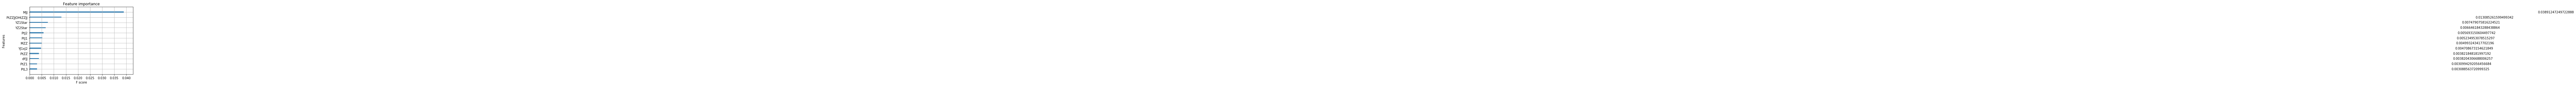

In [53]:
xgb.plot_importance(GBDT,importance_type="gain")

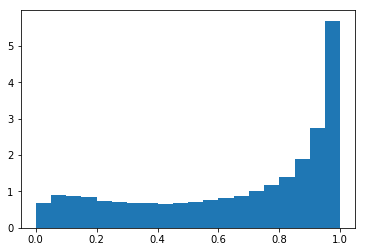

In [54]:
SignalScore=GBDT.predict(BDTSignal)
plt.hist(SignalScore,bins=20,weights=signalArray[:,0])
BackgroundScore=GBDT.predict(BDTBackground)
#plt.hist(BackgroundScore,bins=20)

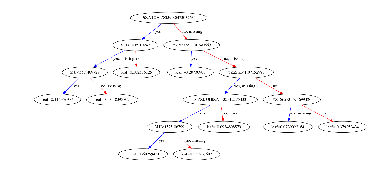

In [55]:
plot_tree(GBDT, num_trees=4)

(array([10.13419176, 10.18759707,  8.23105645,  7.00486283,  6.29250837,
         5.36291331,  4.80064264,  4.34634854,  3.96434417,  3.73812845,
         3.62809181,  3.51660529,  3.62967535,  3.62679511,  3.99162835,
         4.29801459,  4.97383483,  6.27726942,  8.79190453, 16.77181035]),
 array([3.3969874e-04, 5.0322715e-02, 1.0030573e-01, 1.5028875e-01,
        2.0027176e-01, 2.5025478e-01, 3.0023777e-01, 3.5022080e-01,
        4.0020382e-01, 4.5018685e-01, 5.0016987e-01, 5.5015284e-01,
        6.0013586e-01, 6.5011889e-01, 7.0010191e-01, 7.5008494e-01,
        8.0006796e-01, 8.5005093e-01, 9.0003395e-01, 9.5001698e-01,
        1.0000000e+00], dtype=float32),
 <a list of 20 Patch objects>)

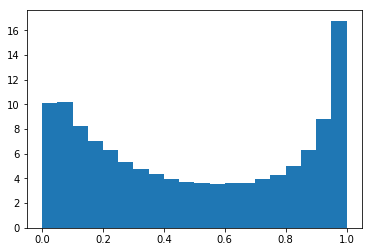

In [56]:
trainScore=GBDT.predict(BDTtrain)
plt.hist(trainScore,bins=20,weights=dataTrainWeight)

In [57]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,trainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)

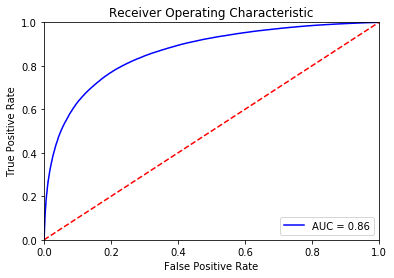

In [58]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [59]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,NNTrainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [60]:
pickle.dump(GBDT, open("GBDT_vbszz.pickle.dat", "wb"))